## What we will do
1. create pinecone vectorstore index
2. index the csv file description
3. reterive relevant csv file description for user question
4. get desired structured output from LLM
5. get python code from LLM and execute it
6. get answer from LLM using the result of the code execution
7. make graph flow of execution step for roboustness

In [34]:
import uuid
import json
import subprocess
import hashlib

import boto3
import pandas as pd

from langchain_aws import BedrockEmbeddings, ChatBedrock
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain_experimental.tools import PythonAstREPLTool
from langchain_pinecone import PineconeVectorStore

from pinecone import Pinecone, ServerlessSpec

In [35]:
index_name = "genese-llm-workshop"
namespace = "tech-tuesday"

pc = Pinecone(api_key="8b444f46-fca7-4b41-a142-463ed4167ba7")

In [36]:
session = boto3.Session(profile_name='genese-llm-acc')
bedrock_client = session.client(
    'bedrock-runtime' , 
    'us-east-1', 
    endpoint_url='https://bedrock-runtime.us-east-1.amazonaws.com'
)

In [37]:
bedrock_embeddings = BedrockEmbeddings(
    client=bedrock_client
)

bedrock_llm = ChatBedrock(
    model_id="anthropic.claude-3-5-sonnet-20240620-v1:0",
    client=bedrock_client,
    model_kwargs={
        "temperature": 0.0
    }
)

In [38]:
len(bedrock_embeddings.embed_query("Hello"))

1536

## create pinecone index

In [39]:
try:
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print("Pinecone index created!!!")
except Exception as pce:
    print(f"Failed to create index due to reason '{pce.reason}' \nError message is '{json.loads(pce.body)['error']['message']}' ")

Failed to create index due to reason 'Conflict' 
Error message is 'Resource  already exists' 


In [40]:
pc.describe_index("genese-llm-workshop")

{'dimension': 1536,
 'host': 'genese-llm-workshop-cksi585.svc.aped-4627-b74a.pinecone.io',
 'metric': 'cosine',
 'name': 'genese-llm-workshop',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
 'status': {'ready': True, 'state': 'Ready'}}

In [41]:
PINECONE_INDEX_HOST = pc.describe_index(index_name)["host"]
pc_index = pc.Index(host=PINECONE_INDEX_HOST)

In [42]:
pc_vectorstore = PineconeVectorStore(
    index=pc_index, 
    embedding=bedrock_embeddings,
    text_key='text',
    namespace=namespace
)

In [43]:
def calculate_hash(text):
    hash = hashlib.sha256()
    hash.update(text.encode('utf-8'))
    hexdigest = hash.hexdigest()
    return hexdigest

In [44]:
def pinecone_upsert(texts, metadatas, ids):
    pc_vectorstore.add_texts(
        texts=texts,
        metadatas=metadatas,
        ids=ids
    )

In [45]:
def pinecone_similarity_search(question, namespace=namespace, k=2, filter=None):
    docs = pc_vectorstore.similarity_search(
        question,
        k=k,
        filter=filter,
        namespace=namespace
    )
    return docs

In [46]:
code_executor = create_python_agent(
    llm=bedrock_llm,
    tool=PythonAstREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    agent_executor_kwargs={
        "handle_parsing_errors": True, 
        "max_iterations": 5, 
        "early_stopping_method": "generate"
    }
)

## Index Documents

In [47]:
csv_file_descriptions = {
    "./datasets/Border_Crossing_Entry_Data.csv": "Border Crossing Entry Data - This dataset provides statistics on inbound crossings at the U.S.-Canada and U.S.-Mexico borders, detailing counts for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Collected by U.S. Customs and Border Protection, the data only covers entries into the U.S.",
    "./datasets/Employment_Unemployment_and_Labor_Force_Data.csv": "Employment Unemployment and Labor Force Data - This dataset uses seasonally adjusted data from the US Bureau of Labor Statistics to present information on Maryland's labor force participation rate, employment rate, and unemployment rate.",
    "./datasets/NYPD_Shooting_Incident_Data_2006.csv": "NYPD Shooting Incident Data 2006 - This dataset provides a detailed breakdown of every shooting incident in NYC from 2006 through the end of the previous calendar year. It includes event details, location, time, and suspect and victim demographics.",
    "./datasets/Warehouse_and_Retail_Sales.csv": "Warehouse and Retail Sales - This dataset contains a list of sales and movement data by item and department appended monthly."    
}

In [48]:
ids = []
metadatas = []
texts = []

for csv_file_path, csv_file_context in csv_file_descriptions.items():
    ids.append(calculate_hash(csv_file_context))
    metadatas.append({"csv_file_path": csv_file_path})
    texts.append(csv_file_context)

In [49]:
pinecone_upsert(texts, metadatas, ids)

## Test Reterival

In [51]:
question = "What was the labor force participation rate in Maryland in January 2007, and how many people were employed?"
docs = pinecone_similarity_search(question)
docs

[Document(page_content="Employment Unemployment and Labor Force Data - This dataset uses seasonally adjusted data from the US Bureau of Labor Statistics to present information on Maryland's labor force participation rate, employment rate, and unemployment rate.", metadata={'csv_file_path': './datasets/Employment_Unemployment_and_Labor_Force_Data.csv'}),
 Document(page_content='NYPD Shooting Incident Data 2006 - This dataset provides a detailed breakdown of every shooting incident in NYC from 2006 through the end of the previous calendar year. It includes event details, location, time, and suspect and victim demographics.', metadata={'csv_file_path': './datasets/NYPD_Shooting_Incident_Data_2006.csv'})]

In [52]:
question = "What are the trends in warehouse sales over the months?"
docs = pinecone_similarity_search(question)
docs

[Document(page_content='Warehouse and Retail Sales - This dataset contains a list of sales and movement data by item and department appended monthly.', metadata={'csv_file_path': './datasets/Warehouse_and_Retail_Sales.csv'}),
 Document(page_content='Border Crossing Entry Data - This dataset provides statistics on inbound crossings at the U.S.-Canada and U.S.-Mexico borders, detailing counts for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Collected by U.S. Customs and Border Protection, the data only covers entries into the U.S.', metadata={'csv_file_path': './datasets/Border_Crossing_Entry_Data.csv'})]

## Csv file path for user question

In [53]:
def prepare_csv_file_context(docs):
    csv_file_context = ""
    
    for doc in docs:
        csv_file_path = doc.metadata["csv_file_path"]
        context = f"For csv file path {csv_file_path} it's file description is as follow:\n" + doc.page_content
        df = pd.read_csv(csv_file_path).head(2)
        df_md = df.to_markdown()
        csv_file_context += context + "It's first 2 rows in markdown format is as follow :\n" + df_md + "\n\n"
    
    csv_file_context = csv_file_context.strip()
    return csv_file_context

In [54]:
csv_file_context = prepare_csv_file_context(docs)
print(csv_file_context)

For csv file path ./datasets/Warehouse_and_Retail_Sales.csv it's file description is as follow:
Warehouse and Retail Sales - This dataset contains a list of sales and movement data by item and department appended monthly.It's first 2 rows in markdown format is as follow :
|    |   YEAR |   MONTH | SUPPLIER                          |   ITEM CODE | ITEM DESCRIPTION          | ITEM TYPE   |   RETAIL SALES |   RETAIL TRANSFERS |   WAREHOUSE SALES |
|---:|-------:|--------:|:----------------------------------|------------:|:--------------------------|:------------|---------------:|-------------------:|------------------:|
|  0 |   2020 |       1 | REPUBLIC NATIONAL DISTRIBUTING CO |      100009 | BOOTLEG RED - 750ML       | WINE        |              0 |                  0 |                 2 |
|  1 |   2020 |       1 | PWSWN INC                         |      100024 | MOMENT DE PLAISIR - 750ML | WINE        |              0 |                  1 |                 4 |

For csv file path ./da

## Schema to reterive result in structured format

In [55]:
csv_file_path_prompt_template = """\
You are provided with csv files with their file description and 2 sample rows in markdown format for additional context.
You are also provided with user question and your task is to return csv file paths that could answer the user question.

User question is as follow:
{question}

CSV file context is as follow:
{csv_file_context}

Please give your final response in the format specified below:
{format_instructions}

NOTE: NO PREAMBLE AND NO POSTAMBLE. JUST GIVE THE DESIRED RESPONSE ONLY IN THE JSON FORMAT SPECIFIED ABOVE.

Your response: 


"""

In [56]:
csv_filepath_schemas = [
    ResponseSchema(
        name="csv_file_paths", 
        description="CSV file paths that could solve the user question.",
        type="array"
    ),
    ResponseSchema(
        name="explanation",
        description="Explanation on why the above csv filepaths were choosen.",
        type="string"
    )
]

csv_filepath_parser = StructuredOutputParser.from_response_schemas(csv_filepath_schemas)

csv_file_path_prompt = PromptTemplate(
    template=csv_file_path_prompt_template,
    input_variables=["question", "csv_file_context"],
    partial_variables={"format_instructions": csv_filepath_parser.get_format_instructions()},
)

csv_file_path_chain = csv_file_path_prompt | bedrock_llm | csv_filepath_parser

In [57]:
def get_pandas_code_from_text(response):
    if '```python' not in response:
        return response.strip()
    elif '```python' in response:
        response = response.split('```python')[-1]
        response = response.split('```')[0]
        response = response.strip()
        return response
    else:
        return None

In [58]:
def get_pandas_agent_prompt(question, resulting_fig_filepath, resulting_csv_filepath, csv_file_paths):
    sample_rows_prompt = "Dataframe first 2 rows for csv filepath is given below: "
    
    for csv_file_path in csv_file_paths:
        df = pd.read_csv(csv_file_path)
        df_md = df.head(2).to_markdown()
        _template = f"""
        
        For csv file path '{csv_file_path}' it's first 2 rows as pandas dataframe in markdown format as follow:
        {df_md}
        
        """
        sample_rows_prompt = sample_rows_prompt + _template

    sample_rows_prompt = sample_rows_prompt.strip()
    
    template = f"""\
    Given the user question, create syntatically correct python code to answer the user question.
    
    User question is as follow:
    {question}

    CSV file paths and their sample rows that could help answer the user question are as follow:
    {sample_rows_prompt}
    
    Strictly follow the following rules while generating python code to answer the user question.
    
    1. Always convert date or datetime or timestamp field if present any to datetime field for consistency using pd.to_datetime()
    2. Always do the following steps for NaN values as preprocessing step.
        2.1 Fill NaNs value using df.ffill(inplace=True) and then
        2.2 Use df.dropna(inplace=True) to drop if any NaNs present after ffill
        statements 2.1 and 2.2 can also be applied to the final dataframe obtained after certain analysis to remove any NaNs from the resulting dataframe.
    3. Always double check if necessary libraries are imported for example code might have used np but import numpy as np might missing from code.
    4. Please use latest version pandas code so that there will be no issue like depreciated warnings.
    5. Always double check if the dataframe column names as well as the variable names in python code are properly defined so that python code generated will not raise error during code execution.
    6. If question is asking for plotting graphs then only include plotting code otherwise do not include plotting code in the generated code, follow below rules for plotting
        6.1 Always use matplotlib or seaborn for plotting
        6.2 Always save the plotting to provided figure filepath which is '{resulting_fig_filepath}' in png format.
    7. At last always save the final resulting dataframe obtained after some data analysis to new csv file in filepath: '{resulting_csv_filepath}' and also limit floating point number upto 2 precisions.
    8. Always include below code snippet in the generated pandas code at very top to supress warning in code execution
        ```python
        import warnings
        warnings.filterwarnings("ignore")
    
    Do not try generate csv filepaths on your own; you are only limited to use csv filepath provided in context above as filepath and sample dataframe rows.
    
    Always give full executable python code as your Final Answer;
    
    NO POSTAMBLE i.e. do no add any text content after python code blocks.
    
    Always give a print statement at the last line of generated python code saying "Python code provided above will give answer to the user question" and \
    if the agent observation is the above print statement then code was executed successfully so you can give your Final Answer which is the python code as it is.
    
    Follow the format below for python agent:
    
    Observation: Result/Error of python code execution
    Thought: Here is the python code to answer the user question
    Action: python_repl_ast
    Action Input:
    ```python
    # python code to answer user question
    ```
        
    Final Answer: ```python

    
    """
    return template

In [59]:
def execute_pandas_agent_chain(question, uuid_str, resulting_csv_filepath, resulting_fig_filepath, csv_file_paths):
    pandas_agent_prompt = get_pandas_agent_prompt(
        question,
        resulting_fig_filepath,
        resulting_csv_filepath,
        csv_file_paths
    )
    response = code_executor.invoke(pandas_agent_prompt)
    python_code = get_pandas_code_from_text(response['output'])
    print("\n\nPython code is ::: \n\n", python_code)
    return python_code

## Generate python code

In [60]:
csv_file_path_chain_response = csv_file_path_chain.invoke({
    "question": question,
    "csv_file_context": csv_file_context
})

csv_file_paths = csv_file_path_chain_response["csv_file_paths"]

In [61]:
csv_file_paths

['./datasets/Warehouse_and_Retail_Sales.csv']

In [62]:
try:
    uuid_str = uuid.uuid4()
    resulting_fig_filepath = f"/tmp/{uuid_str}.png"
    resulting_csv_filepath = f"/tmp/{uuid_str}.csv"
    
    pandas_code = execute_pandas_agent_chain(
        question,
        uuid_str,
        resulting_csv_filepath,
        resulting_fig_filepath,
        csv_file_paths
    )
except Exception as ex:
    print(ex)
    python_code = None



> Entering new AgentExecutor chain...
To answer the user question about trends in warehouse sales over the months, we need to analyze the data from the provided CSV file. Let's create a Python script that reads the data, processes it, and calculates the monthly warehouse sales trends.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('./datasets/Warehouse_and_Retail_Sales.csv')

# Convert YEAR and MONTH to datetime
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2) + '-01')

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Group by DATE and sum the WAREHOUSE SALES
monthly_sales = df.groupby('DATE')['WAREHOUSE SALES'].sum().reset_index()

# Sort the data by date
monthly_sales = monthly_sales.sort_values('DATE')

# Calculate the trend u

In [64]:
!head -10 /tmp/cc03c5e2-e016-4886-b6a2-34298e143807.csv

DATE,WAREHOUSE SALES,Trend
2017-06-01,379390.83,
2017-07-01,316853.29,
2017-08-01,382186.69,359476.94
2017-09-01,305440.53,334826.84
2017-10-01,303714.91,330447.38
2017-11-01,339305.66,316153.7
2017-12-01,306957.22,316659.26
2018-01-01,254517.67,300260.18
2018-02-01,265008.52,275494.47


## Answer generation from data

In [65]:
answer_prompt_template = """\
You are provided with the user data question and resulting csv dataframe in markdown string for that user question.
Please give answer for that question by analysing the result provided.

User question is as follow:
{question}

Resulting csv file dataframe in markdown string is as follow:
{df_md}

Please use format specified below to give your final answer.
{format_instructions}

NO PREMABLE and NO POSTAMBLE

Your Answer: 


"""

In [66]:
answer_schemas = [
    ResponseSchema(
        name="answer", 
        description="Answer for the user question.",
        type="string"
    )
]

answer_parser = StructuredOutputParser.from_response_schemas(answer_schemas)

answer_prompt = PromptTemplate(
    template=answer_prompt_template,
    input_variables=["question", "df_md"],
    partial_variables={"format_instructions": answer_parser.get_format_instructions()},
)

answer_chain = answer_prompt | bedrock_llm | answer_parser

In [67]:
def prepare_df_md(resulting_csv_filepath):
    df = pd.read_csv(resulting_csv_filepath)
    df = df.head(10)
    df_md = df.to_markdown(index=False)
    return df_md

In [68]:
def prepare_answer(question, resulting_csv_filepath):
    df_md = prepare_df_md(resulting_csv_filepath)
    
    answer_chain_response = answer_chain.invoke({
        "question": question,
        "df_md": df_md
    })
    return answer_chain_response['answer']

In [69]:
answer = prepare_answer(
    question,
    "/tmp/cc03c5e2-e016-4886-b6a2-34298e143807.csv"
)
print(answer)

Based on the provided data, the trends in warehouse sales over the months show an overall declining pattern. The trend values, which represent a moving average, decrease from 359,477 in August 2017 to 266,636 in January 2019. There are some fluctuations in the actual monthly sales, with the highest sales of 382,187 in August 2017 and the lowest of 254,518 in January 2018. The trend line suggests a gradual decrease in warehouse sales over time, with a more pronounced decline in the latter part of 2017 and early 2018. It's important to note that there's a significant gap in the data between February 2018 and January 2019, which may affect the interpretation of long-term trends.


In [70]:
def save_pandas_code(pandas_code, pandas_code_filepath):
    with open(pandas_code_filepath, 'w') as wf:
        wf.write(pandas_code)
    return pandas_code_filepath

In [71]:
def execute_pandas_code(pandas_code_filepath):
    process = subprocess.Popen(["python3", pandas_code_filepath], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    output, error = process.communicate()
    if error:
        print("Error on executing code ::: ", error)
        success = False
    else:
        success = True
    return success, error

## Langgraph Implementation

In [72]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict

In [78]:
class GraphState(TypedDict):
    """
    question : user question
    uuid_str : uuid string for making file names
    namespace : pinecone index namespace
    top_k : number of relevant docs to retrieve
    csv_file_paths: csv file paths that could solve user question
    csv_file_paths_context : csv file descriptions from vector store
    pandas_code : pandas code obtained from LLM
    pandas_code_filepath : pandas code saved file path
    resulting_csv_filepath : csv file path where resulting dataframe is saved after code execution
    resulting_fig_filepath : fig file path where resulting figure is saved after code execution
    pandas_code_executed : wether pandas code executed or not
    answer : answer of the question or fallback message
    """
    question: str
    uuid_str: str
    namespace: str
    top_k: int
    csv_file_paths_context: str
    csv_file_paths: List[str]
    pandas_code: str
    pandas_code_filepath: str
    resulting_csv_filepath: str
    resulting_fig_filepath: str
    pandas_code_executed: bool
    answer: str

In [79]:
def retrieve_csv_file_paths_context(state):
    print("----- RETRIEVE RELEVANT CSV FILE CONTEXT -----")

    question = state["question"]
    namespace = state["namespace"]
    top_k = state["top_k"]
    
    docs = pinecone_similarity_search(
        question,
        k=top_k,
        namespace=namespace
    )
    csv_file_paths_context = prepare_csv_file_context(docs)
    
    return {
        "csv_file_paths_context": csv_file_paths_context
    }


def extract_csv_file_paths(state):
    print("----- EXTRACT CSV PATHS -----")
    
    question = state["question"]
    csv_file_paths_context = state["csv_file_paths_context"]

    csv_file_path_chain_response = csv_file_path_chain.invoke({
        "question": question,
        "csv_file_context": csv_file_paths_context
    })
    csv_file_paths = csv_file_path_chain_response["csv_file_paths"]
    print(csv_file_paths)
    
    return {
        "csv_file_paths": csv_file_paths
    }


def generate_pandas_code(state):
    print("----- GENERATE PANDAS CODE -----")

    question = state["question"]
    uuid_str = state["uuid_str"]
    csv_file_paths = state["csv_file_paths"]

    resulting_csv_filepath = f"/tmp/{uuid_str}.csv"
    resulting_fig_filepath = f"/tmp/{uuid_str}.png"
    
    try:
        pandas_code = execute_pandas_agent_chain(
            question,
            uuid_str,
            resulting_csv_filepath,
            resulting_fig_filepath,
            csv_file_paths
        )
    except Exception as ex:
        print(ex)
        python_code = None
    
    if pandas_code:
        return {
            "pandas_code": pandas_code,
            "resulting_csv_filepath": resulting_csv_filepath,
            "resulting_fig_filepath": resulting_fig_filepath,
            "pandas_code_executed": True
        }
    else:
        return {
            "pandas_code_executed": False
        }


def check_if_pandas_code_executed_successfully(state):
    print("----- CHECK IF PANDAS CODE EXECUTED SUCCESSFULLY -----")

    pandas_code_executed = state["pandas_code_executed"]
    if pandas_code_executed:
        return "generate_answer_for_question"
    else:
        return "pandas_code_execution_fallback"


def pandas_code_execution_fallback(state):
    print("----- PANDAS CODE EXECUTION FALLBACK -----")

    return {
        "answer": "Failed to execute pandas code; may be code generate was wrong with multiple retries. Please try again later!"
    }


def generate_answer_for_question(state):
    print("----- GENERATE ANSWER FOR QUESTION -----")

    question = state["question"]
    resulting_csv_filepath = state["resulting_csv_filepath"]
    
    df_md = prepare_df_md(resulting_csv_filepath)
    
    answer_chain_response = answer_chain.invoke({
        "question": question,
        "df_md": df_md
    })
    answer = answer_chain_response['answer']

    return {
        "answer": answer
    }
    

def final_response(state):
    print("----- FINAL RESPONSE -----")
    
    answer = state["answer"]

    return {
        "answer": answer
    }

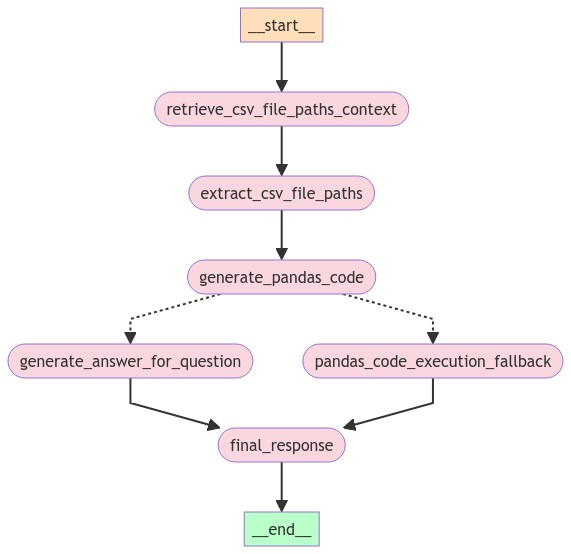

In [80]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve_csv_file_paths_context", retrieve_csv_file_paths_context)
workflow.add_node("extract_csv_file_paths", extract_csv_file_paths)
workflow.add_node("generate_pandas_code", generate_pandas_code)
workflow.add_node("pandas_code_execution_fallback", pandas_code_execution_fallback)
workflow.add_node("generate_answer_for_question", generate_answer_for_question)
workflow.add_node("final_response", final_response)

workflow.add_edge("retrieve_csv_file_paths_context", "extract_csv_file_paths")
workflow.add_edge("extract_csv_file_paths", "generate_pandas_code")

workflow.add_conditional_edges(
    "generate_pandas_code",
    check_if_pandas_code_executed_successfully,
    {
        "pandas_code_execution_fallback": "pandas_code_execution_fallback",
        "generate_answer_for_question": "generate_answer_for_question"
    }
)

workflow.add_edge("pandas_code_execution_fallback", "final_response")
workflow.add_edge("generate_answer_for_question", "final_response")

workflow.add_edge(START, "retrieve_csv_file_paths_context")
workflow.add_edge("final_response", END)

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [82]:
question = "What was the labor force participation rate in Maryland in January 2007, and how many people were employed?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Employment_Unemployment_and_Labor_Force_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user's question about the labor force participation rate in Maryland in January 2007 and the number of people employed, I'll need to write Python code to read and analyze the provided CSV file. Here's the code to do that:

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Handle NaN values
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for January 2007
jan_2007 = df[(df['Year'] == 2007) & (df['Month'] == 1)]

# Extract required information
labor_force_participation_rate = jan_2007['Labor Forc

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Warehouse_and_Retail_Sales.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user's question about trends in warehouse sales over the months, we need to analyze the data from the CSV file and create a chart to visualize the trends. Let's write the Python code to accomplish this task.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('./datasets/Warehouse_and_Retail_Sales.csv')

# Convert YEAR and MONTH to datetime
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2) + '-01')

# Group by DATE and sum the WAREHOUSE SALES
monthly_sales = df.groupby('DATE')['WAREHOUSE SALES'].sum().reset_index()

# Sort the dataframe by DATE
monthly_sales = monthly_sales.sor

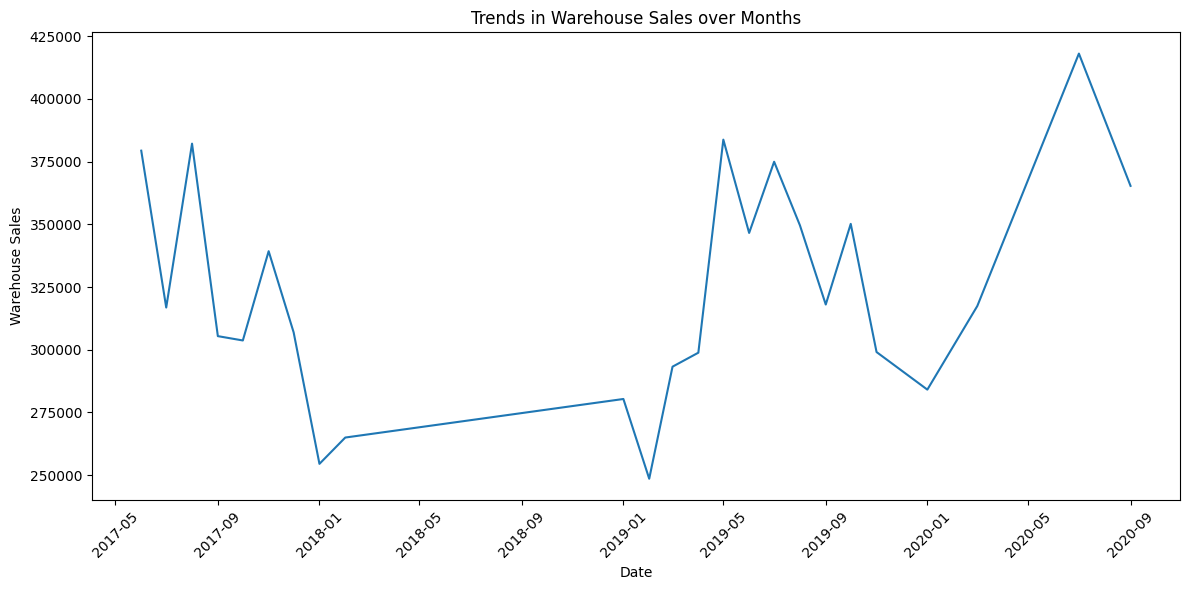

In [83]:
question = "What are the trends in warehouse sales over the months? Show the chart and explain it as well."
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/NYPD_Shooting_Incident_Data_2006.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about comparing the demographics of suspects and victims in shooting incidents, we need to analyze the data from the provided CSV file. Let's write a Python script to load the data, process it, and compare the demographics.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('./datasets/NYPD_Shooting_Incident_Data_2006.csv')

# Convert date to datetime
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE'])

# Handle NaN values
df.ffill(inplace=True)
df.dropna(inplace=True)

# Compare demographics of suspects (PERP) and victims (VIC)
demographics = ['AGE_GROUP', 'SEX', 'RACE']

result = pd.DataFrame()

for demo

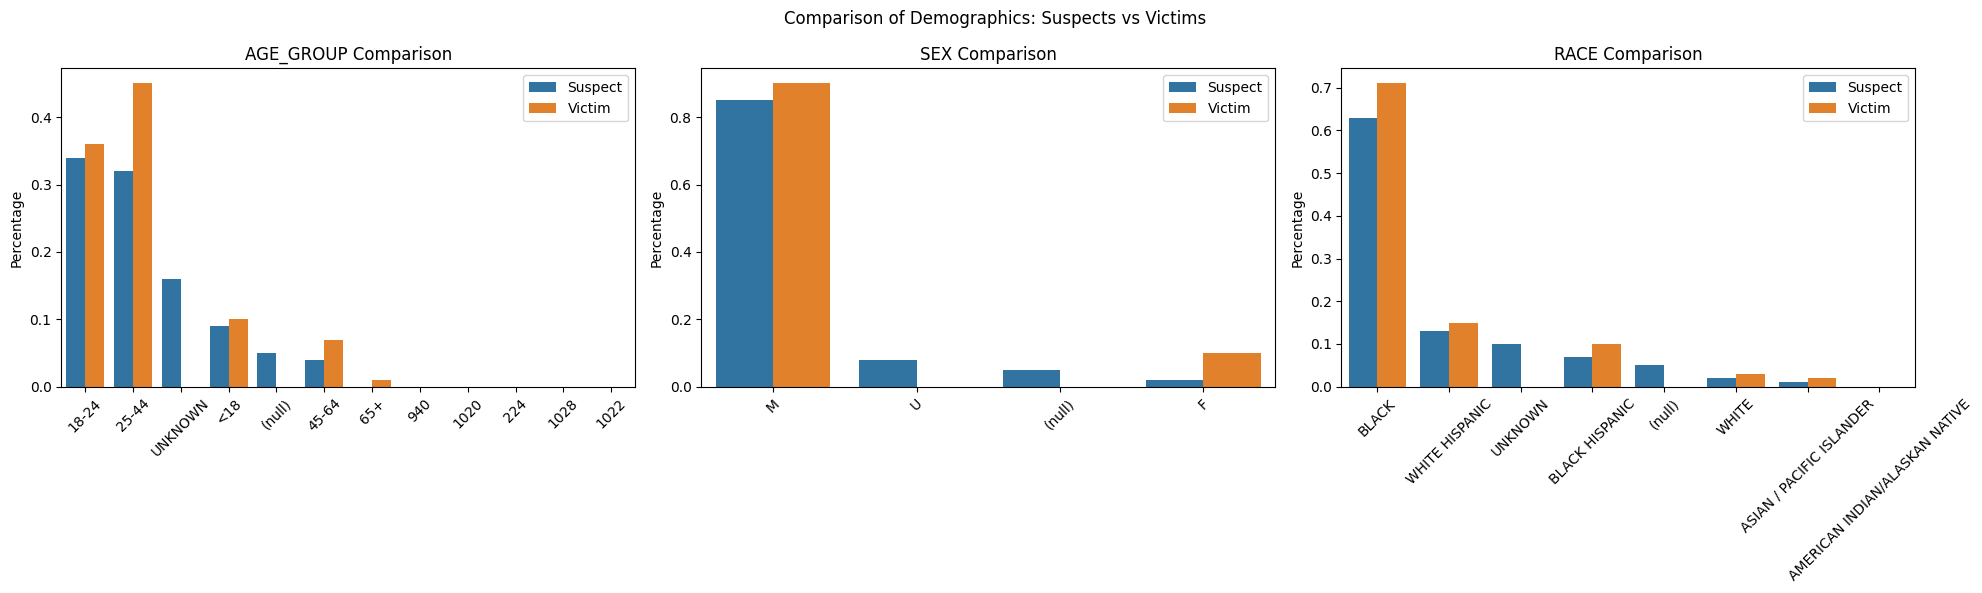

In [85]:
question = "How do the demographics of suspects compare to those of victims in shooting incidents?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print(output["answer"])

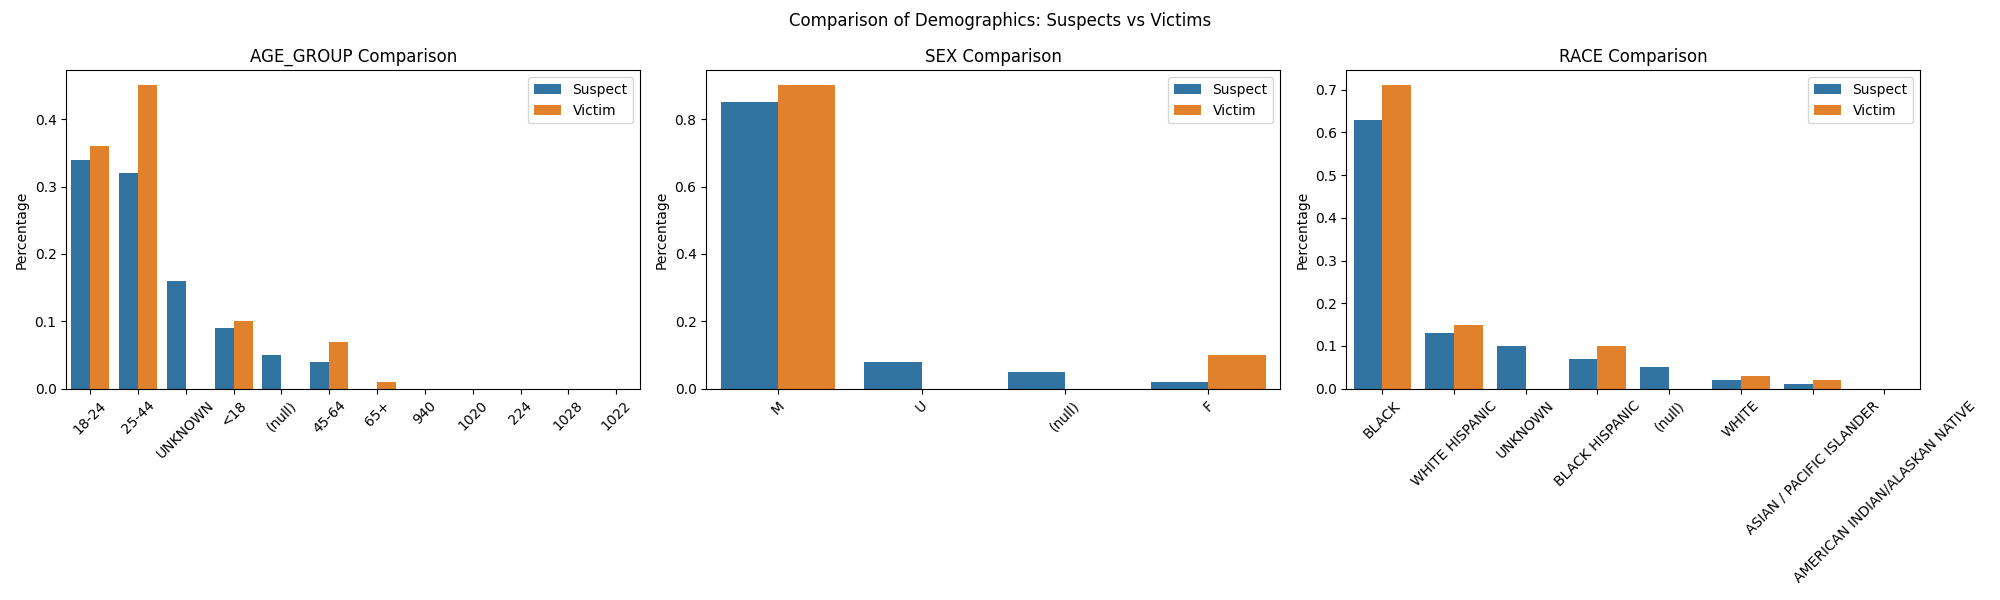

In [87]:
Image(filename='/tmp/b580bfc4-47ed-4545-a97f-af341b810c94.png')

In [88]:
question = "What are the trends in shooting incidents over the years?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/NYPD_Shooting_Incident_Data_2006.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about trends in shooting incidents over the years, we need to analyze the data from the provided CSV file. Let's write a Python script to load the data, process it, and visualize the trends.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('./datasets/NYPD_Shooting_Incident_Data_2006.csv')

# Convert OCCUR_DATE to datetime
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Group by year and count incidents
yearly_incidents = df.groupby(df['OCCUR_DATE'].dt.year).size().reset_index(name='Incidents')

# Plo

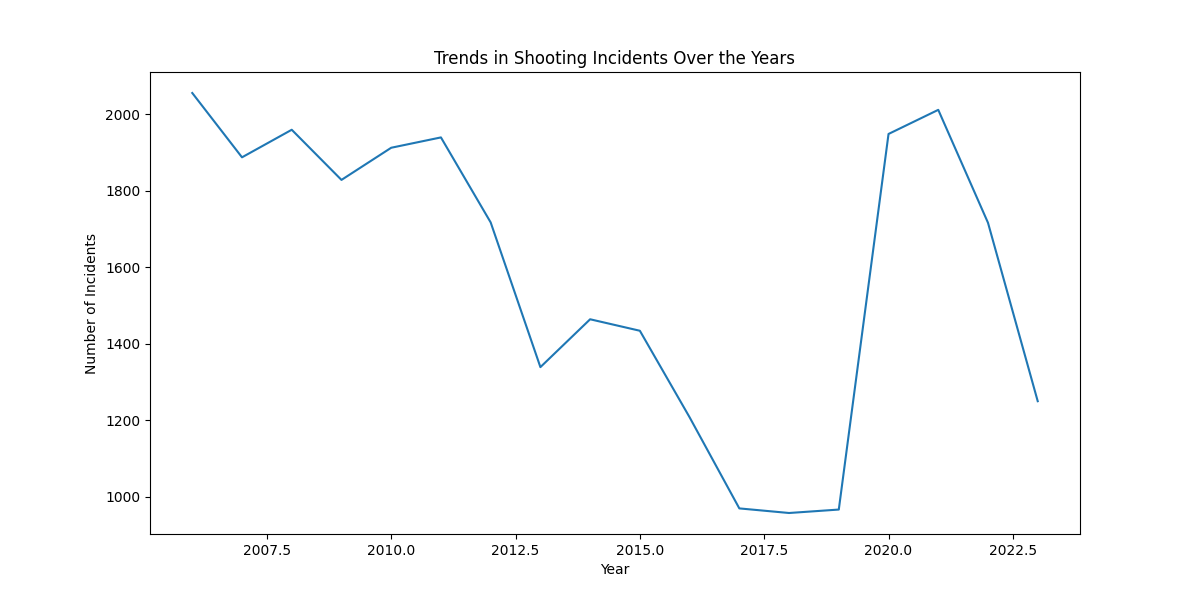

In [89]:
Image('/tmp/149bfe78-6c06-4384-8c7e-ba1866e7354a.png')

In [90]:
question = "Which borough has the highest number of shooting incidents?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/NYPD_Shooting_Incident_Data_2006.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question "Which borough has the highest number of shooting incidents?", we need to analyze the data from the provided CSV file. Let's write a Python script to read the data, process it, and find the borough with the highest number of shooting incidents.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('./datasets/NYPD_Shooting_Incident_Data_2006.csv')

# Convert date to datetime
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE'])

# Handle NaN values
df.ffill(inplace=True)
df.dropna(inplace=True)

# Count the number of incidents per borough
borough_counts = df['BORO'].value_counts().reset_index()
borough_counts.columns = ['Borough', 'Incidents

In [91]:
question = "What is the correlation between the civilian labor force and the employment rate?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Employment_Unemployment_and_Labor_Force_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user's question about the correlation between the civilian labor force and the employment rate, we need to analyze the data from the provided CSV file. Let's write a Python script to load the data, preprocess it, calculate the correlation, and save the results.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaN rows
df.ffill(inplace=True)
df.dropna(inplace=True)

# Calculate employment rate if not already present
if 'Employment Rate' not in df.columns:
    df['Employme

In [92]:
question = "What are the trends in different types of crossings (trucks, buses, pedestrians, etc.) over the past five years?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Border_Crossing_Entry_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about trends in different types of crossings over the past five years, we need to analyze the Border Crossing Entry Data. Let's write a Python script to process the data, filter for the last five years, and analyze the trends for different types of crossings.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Read the CSV file
df = pd.read_csv('./datasets/Border_Crossing_Entry_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for the last 5 years
end_date = df['Date'

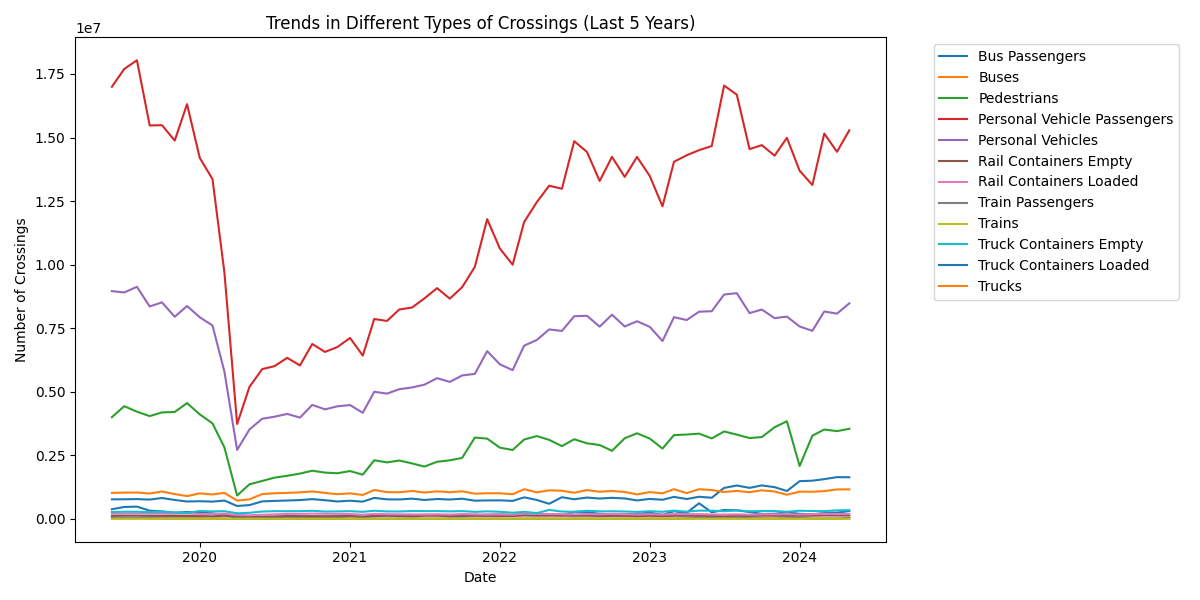

In [93]:
Image('/tmp/c2180cf9-6d65-4a42-ad88-bbc95ec8cf7e.png')

In [94]:
question = "Which states have the most active ports in terms of crossings?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 1
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Border_Crossing_Entry_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about which states have the most active ports in terms of crossings, we need to analyze the Border Crossing Entry Data. Let's write a Python script to process the data, group it by state, and calculate the total crossings for each state.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('./datasets/Border_Crossing_Entry_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Group by State and sum the Value column
state_crossings = df.groupby('State')['Value'].sum().reset_index()

# Sort the states by total crossings in des

## question requires 2 csv files

In [100]:
question = "Is there a correlation between border crossing entries and the employment rate in border states?"
inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 2
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/Border_Crossing_Entry_Data.csv', './datasets/Employment_Unemployment_and_Labor_Force_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about the correlation between border crossing entries and the employment rate in border states, we need to analyze and combine data from both CSV files. Let's create a Python script that processes this data and calculates the correlation.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV files
border_crossing_df = pd.read_csv('./datasets/Border_Crossing_Entry_Data.csv')
employment_df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert date columns to datetime
border_crossing_df['Date'] = pd.to_datetime(border_c

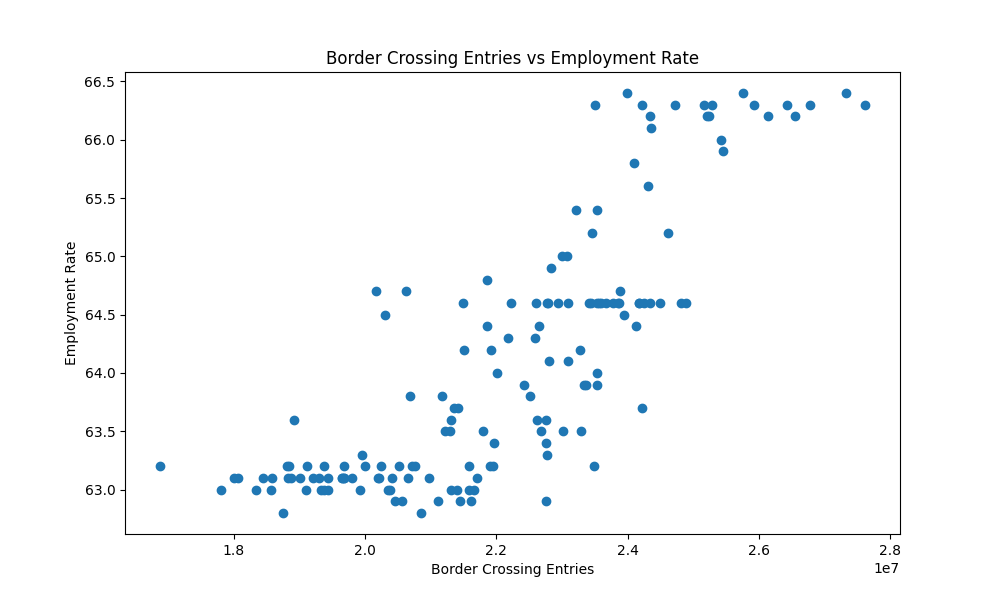

In [101]:
Image('/tmp/88b28b0e-cb1d-458a-8b22-a53a4076e50d.png')

----- RETRIEVE RELEVANT CSV FILE CONTEXT -----
----- EXTRACT CSV PATHS -----
['./datasets/NYPD_Shooting_Incident_Data_2006.csv', './datasets/Employment_Unemployment_and_Labor_Force_Data.csv']
----- GENERATE PANDAS CODE -----


> Entering new AgentExecutor chain...
To answer the user question about how the Unemployment Rate impacts the number of shooting incidents in NYC boroughs, we need to analyze and combine data from both CSV files provided. Let's write a Python script to process this data and find the correlation between unemployment rates and shooting incidents.

Action: python_repl_ast
Action Input:
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
shooting_df = pd.read_csv('./datasets/NYPD_Shooting_Incident_Data_2006.csv')
employment_df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert date columns to datetime
shooting

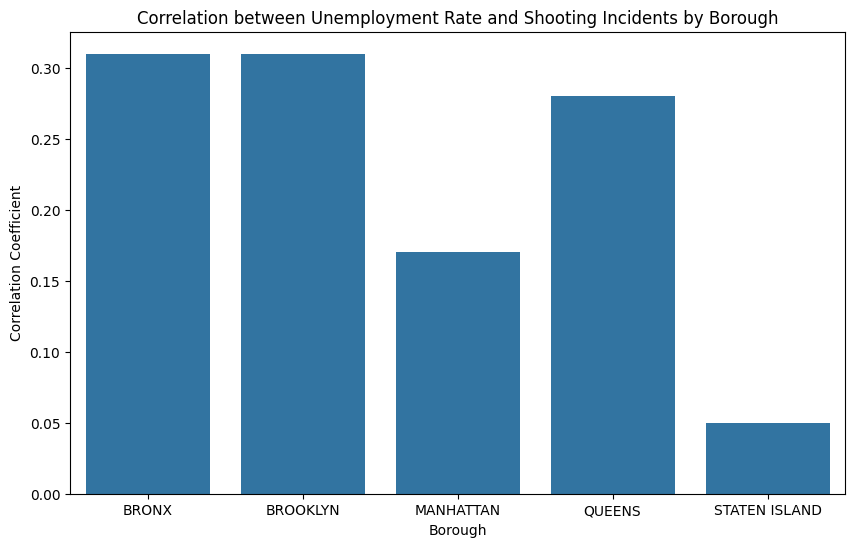

In [105]:
question = "How does the Unemployment Rate impact the number of shooting incidents in NYC boroughs?"

inputs = {
    "question": question,
    "uuid_str": str(uuid.uuid4()),
    "namespace": namespace,
    "top_k": 2
}

output = app.invoke(inputs)
print("\n\n")
print(output["answer"])